In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [2]:
def solve_eigenproblem_square(parameters, energy = 1e-6, number_of_bands = int(1),plot_shape = True):
    Nx = parameters['Nx']     # Number of unit cells in x direction
    Ny = parameters['Ny']     # Number of unit cells in y direction
    #Generate Peierls phases
    np.random.seed(0)
    fluxes = tb.make_fluxes(parameters)
    a_e, a_n = tb.vector_potential(parameters,fluxes)
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    

    if plot_shape:
        Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_square(parameters, return_shape = True)
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111)
        ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
        ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
        ax.set_aspect('equal')
        fig.show()
    else:
        Phi, H, P, deleted_indices = operators_square(parameters, return_shape = False)

      #Solve generalised eigenproblem
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 0, sigma = energy, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)

    ##### This following part is specific for the square ######
    edge_points, normal_angles = generate_square(L = min(Nx,Ny)-1)
    edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
      # Now rotate back the spins on the edge
    theta = parameters['theta']
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]+pi)
        

    ###Now reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Now assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0 #This should be zero
        else:
            energies[i] = eigenvalues[i]
    
    return energies, states_shaped, degenerate_indices

In [3]:
def operators_square(parameters, plot_potential = False, plot_mass = False, plot_mag_field = False,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = 0    # open system
    ky = 0    # open system
    
    #Generate Peierls phases
    #np.random.seed(0)
    if parameters['B1'] == 0:
        a_e = np.zeros((Ny,Nx))
        a_n = np.zeros((Ny,Nx))
    else:
        fluxes = make_fluxes(parameters, plot = plot_mag_field)
        a_e, a_n = vector_potential(parameters,fluxes)
        
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Peierls phases
        p_e = np.exp(1j*(a_e[y,x]))
        p_n = np.exp(1j*(a_n[y,x]))
        
        #Standard translations
        trs_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        trs_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        #Total phases
        phase_e = p_e*trs_e
        phase_n = p_n*trs_n
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    potential_array = tb.make_potential(parameters, plot = plot_potential).flatten()    
    pot = scipy.sparse.spdiags(potential_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    V = scipy.sparse.kron(csc_matrix(sigma_0), pot, format = "csc")    
    
    mass_array = tb.make_mass(parameters, plot = plot_mass).flatten()    
    mass = scipy.sparse.spdiags(mass_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@V@Phi + Phi.H@M@Phi

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_square(L=min(Nx,Ny)-1)
    edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    indices_to_delete = []
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        L = min(Nx,Ny)-1
        return (np.abs(x-y)+np.abs(x+y))/L
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if discriminant(x-Nx//2,y-Ny//2)>1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins (could I avoid this?)
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

In [4]:
def generate_square(L,npoints=1000000):
    'Generates the set of points in the grid closest to an square with radii r1 and r2 and the angle of the normal vector.'
    length = np.linspace(0, 4*L, npoints, endpoint = False)
    
    x = np.zeros(npoints)
    y = np.zeros(npoints)
    angles = np.zeros(npoints)
    

    x = np.where(np.abs(length-L/2)<=L/2,L/2*np.ones(npoints),x)
    y = np.where(np.abs(length-L/2)<=L/2,np.linspace(-L/2,4*L-L/2,npoints, endpoint = False),y)
    angles = np.where(np.abs(length-L/2)<=L/2,np.zeros(npoints),angles)

    x = np.where(np.abs(length-3*L/2)<=L/2,np.linspace(3*L/2,3*L/2-4*L,npoints, endpoint = False),x)
    y = np.where(np.abs(length-3*L/2)<=L/2,L/2*np.ones(npoints),y)
    angles = np.where(np.abs(length-3*L/2)<=L/2,pi/2*np.ones(npoints),angles)

    x = np.where(np.abs(length-5*L/2)<=L/2,-L/2*np.ones(npoints),x)
    y = np.where(np.abs(length-5*L/2)<=L/2,np.linspace(5*L/2,5*L/2-4*L,npoints, endpoint = False),y)
    angles = np.where(np.abs(length-5*L/2)<=L/2,pi*np.ones(npoints),angles)

    x = np.where(np.abs(length-7*L/2)<=L/2,np.linspace(-7*L/2,-7*L/2+4*L,npoints, endpoint = False),x)
    y = np.where(np.abs(length-7*L/2)<=L/2,-L/2*np.ones(npoints),y)
    angles = np.where(np.abs(length-7*L/2)<=L/2,3*pi/2*np.ones(npoints),angles)

    
    z = np.exp(1j*angles)


    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    
    
    return boundary_points, normal_angles

In [5]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

i =  -1 ### selected value of theta
Nx = 76
Ny = 76
L = min(Nx,Ny)-1
nbands = int((L*L)/100*16)
print('Bands to calculate: ',nbands)


parameters = dict(
    Nx = Nx,
    Ny = Ny,
    B1 = 0, # no magnetic field
    N1 = 0, #
    d1 = 0, # These are irrelevant for B1 = 0
    N2 = 0, #
    potential = lambda x,y:0.0*np.random.rand(Ny,Nx),
    mass = lambda x,y:0*x,
    disorder = 0,
    theta = -(pi/2)*(thetas[i]/100),
)

Bands to calculate:  900


/tmp/ipykernel_12651/810994691.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_12651/810994691.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


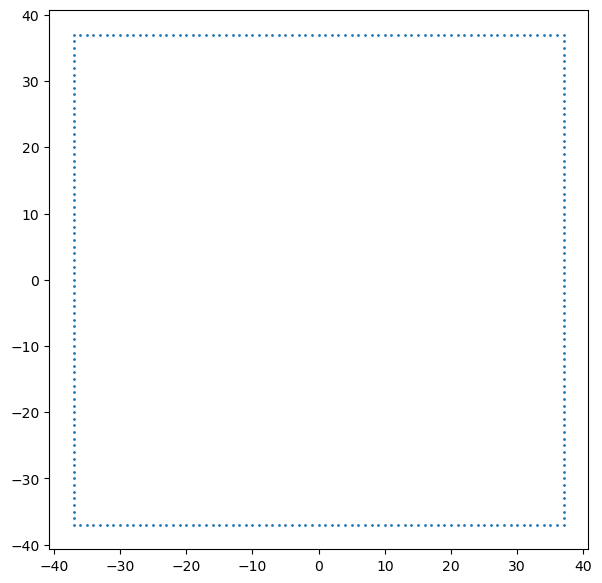

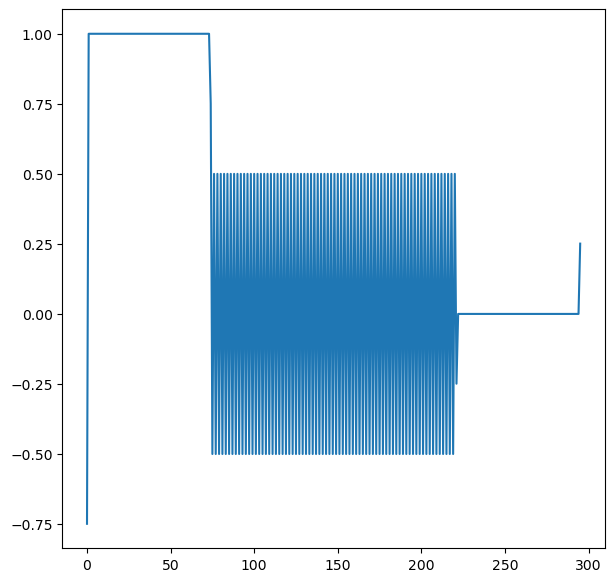

In [38]:
boundary_points, normal_angles = tb.generate_square(Nx)
#NNpoints = len(boundary_points[0]//40)
NNpoints = len(boundary_points[0])
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(boundary_points[0,:NNpoints],boundary_points[1,:NNpoints], s = 1)

ax.set_aspect('equal')
fig.show()

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.plot(normal_angles[:NNpoints]/pi)

fig.show()

/tmp/ipykernel_12651/3311762510.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


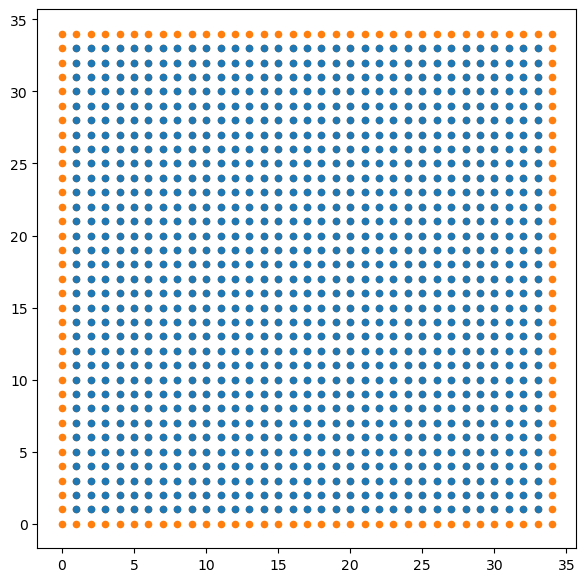

In [29]:
ener, states, degenerate_indices = solve_eigenproblem_square(parameters, number_of_bands = nbands, plot_shape = True)

/tmp/ipykernel_12651/3807811563.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_12651/3807811563.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (3,3))


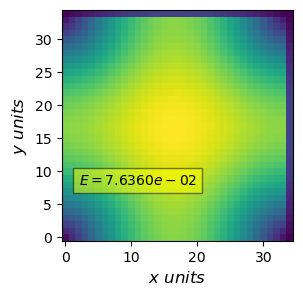

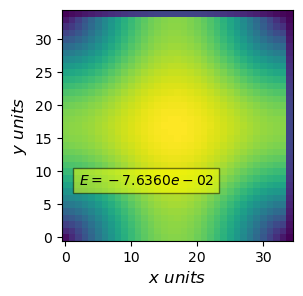

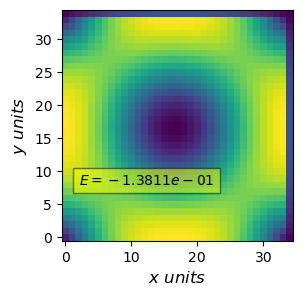

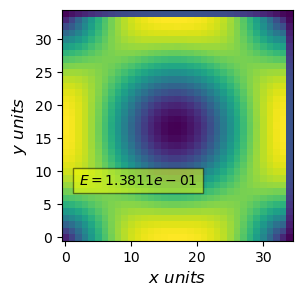

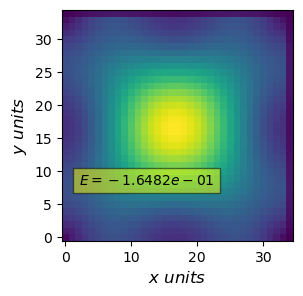

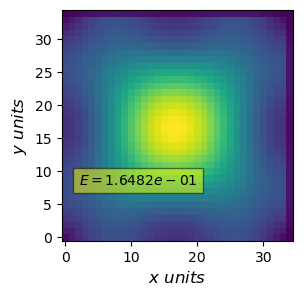

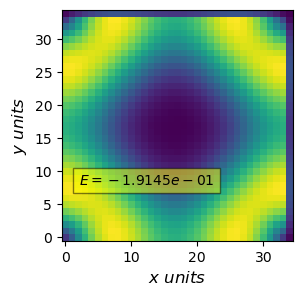

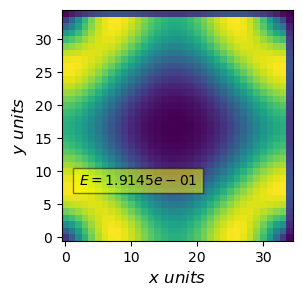

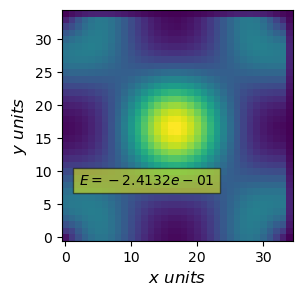

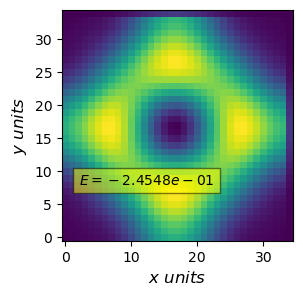

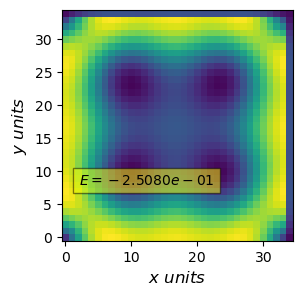

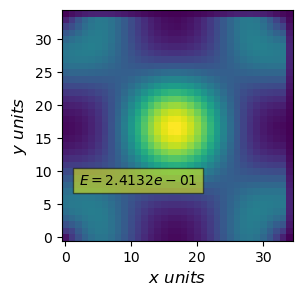

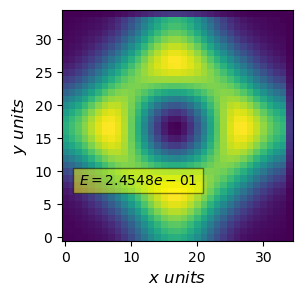

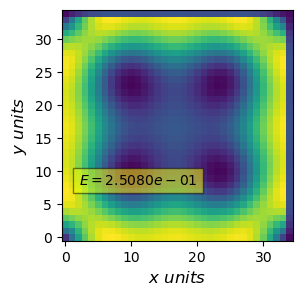

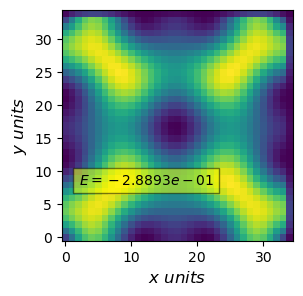

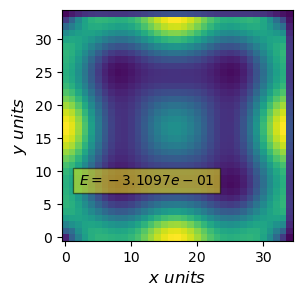

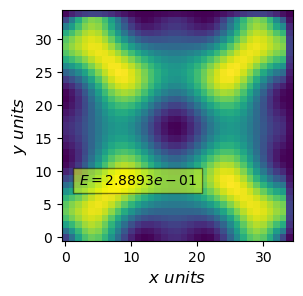

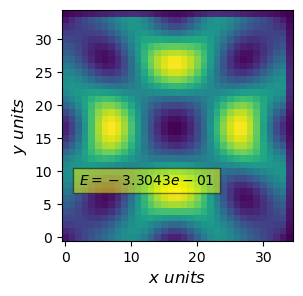

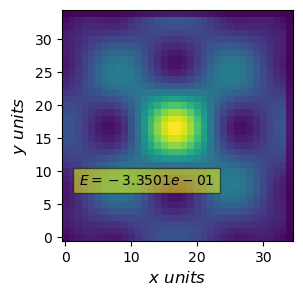

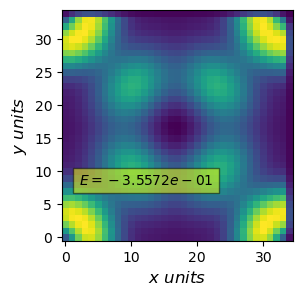

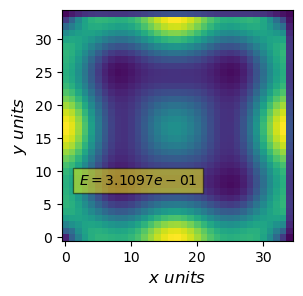

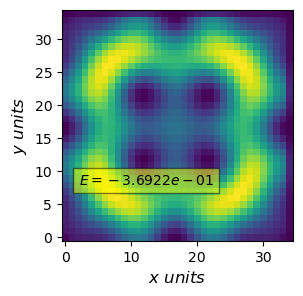

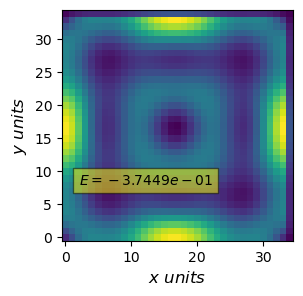

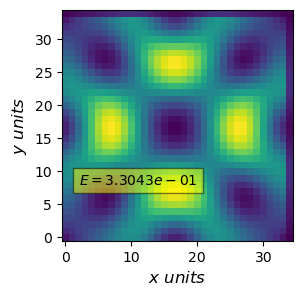

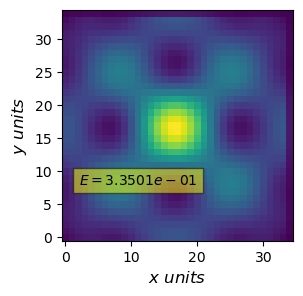

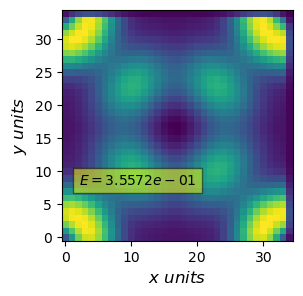

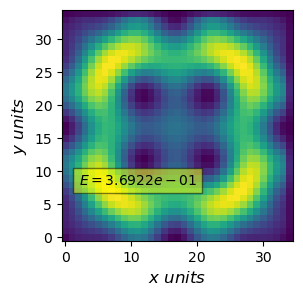

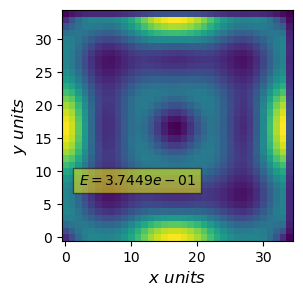

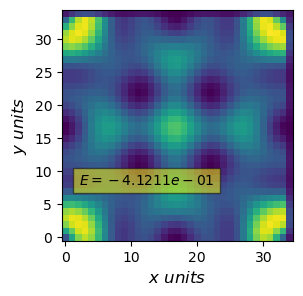

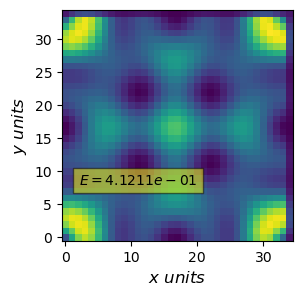

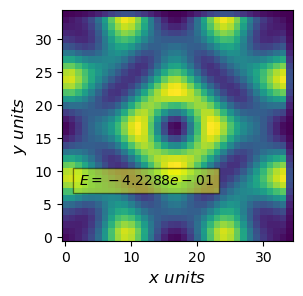

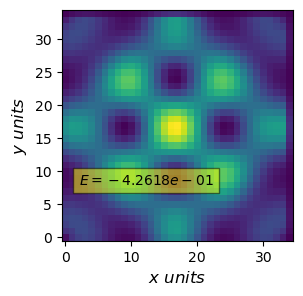

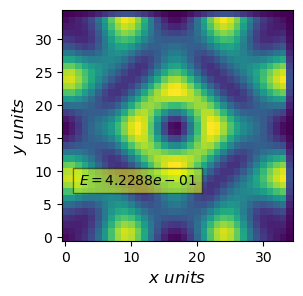

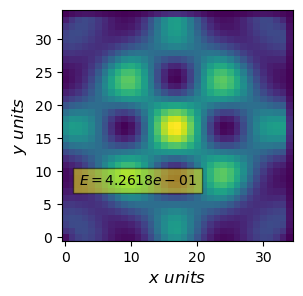

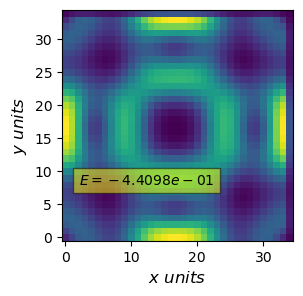

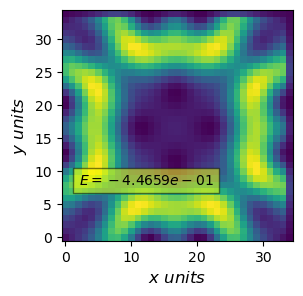

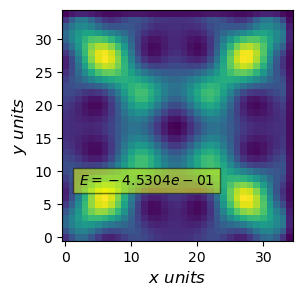

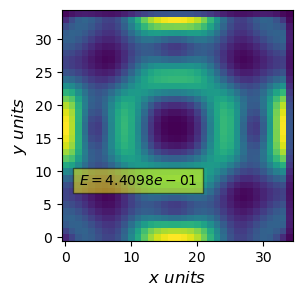

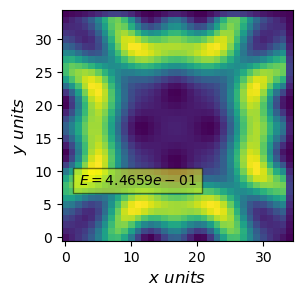

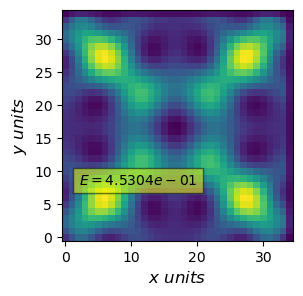

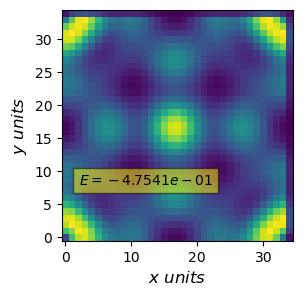

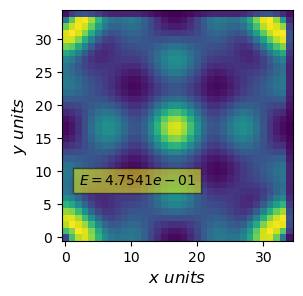

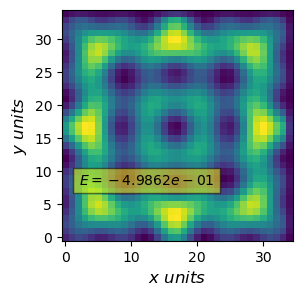

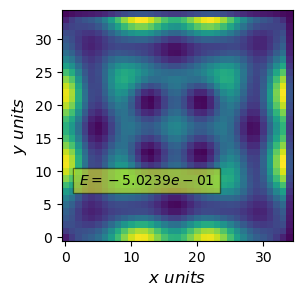

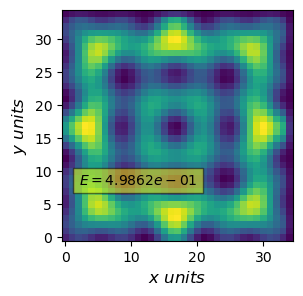

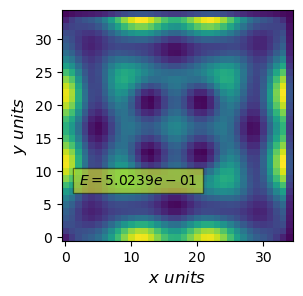

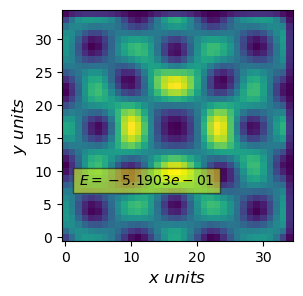

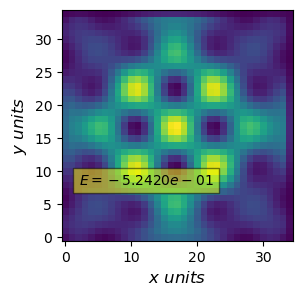

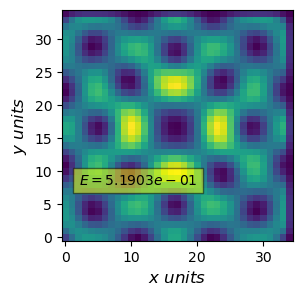

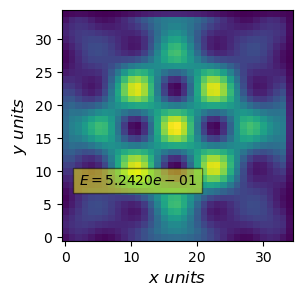

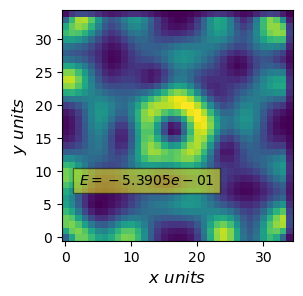

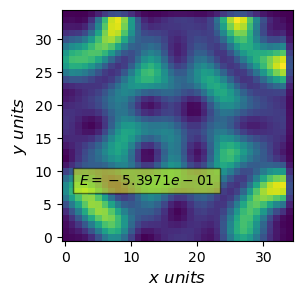

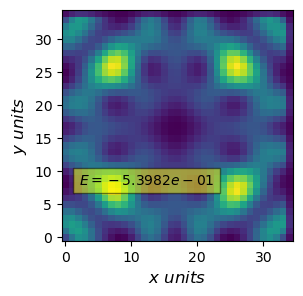

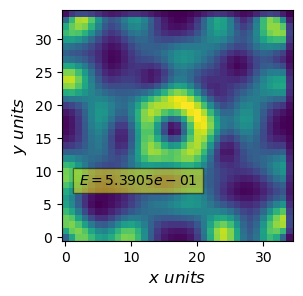

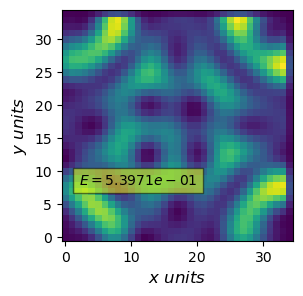

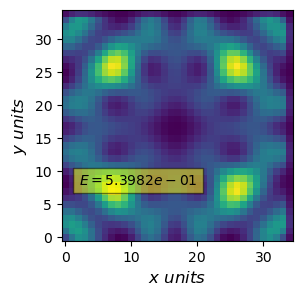

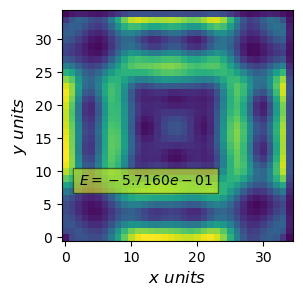

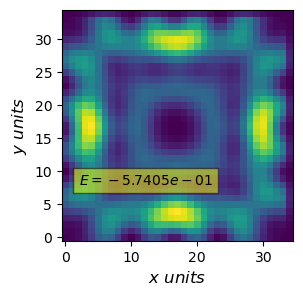

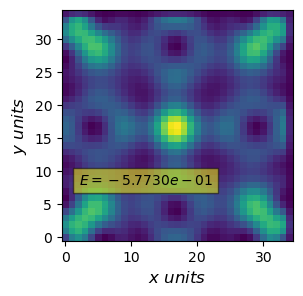

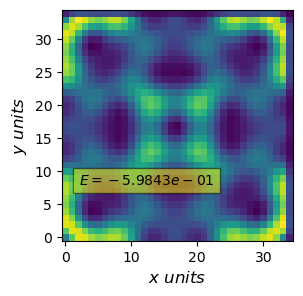

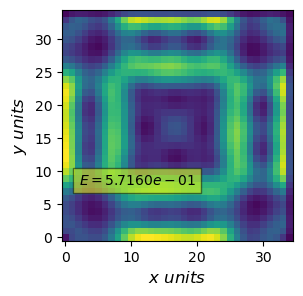

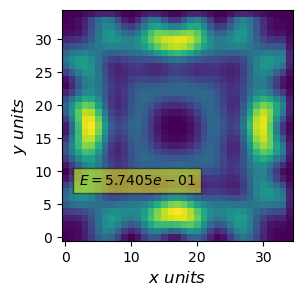

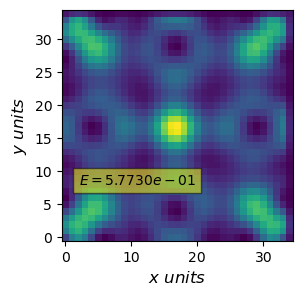

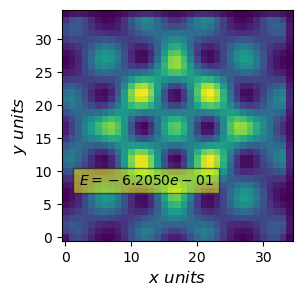

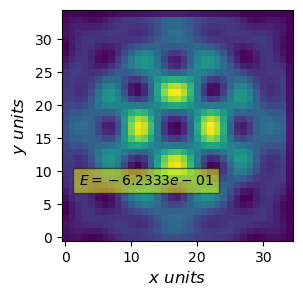

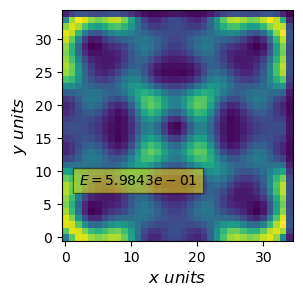

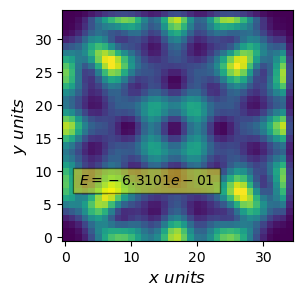

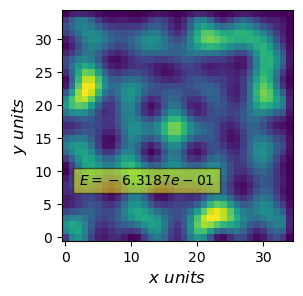

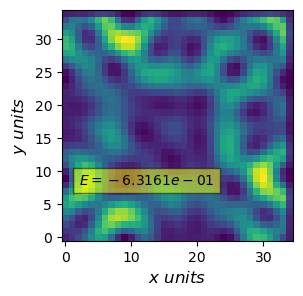

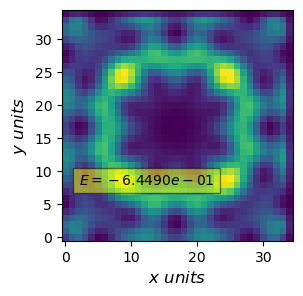

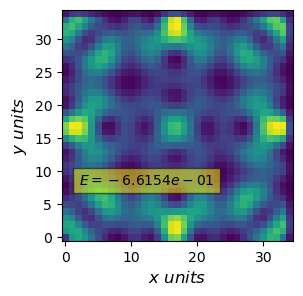

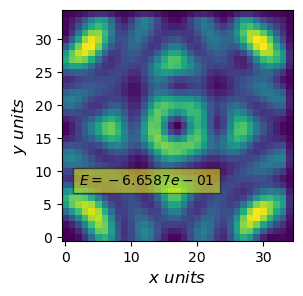

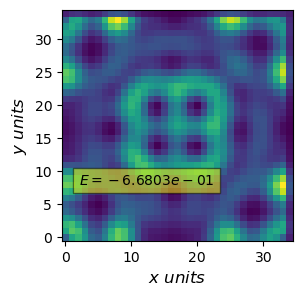

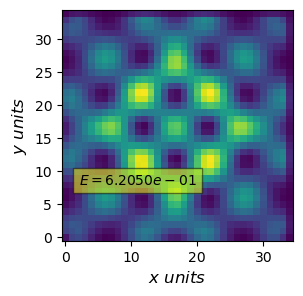

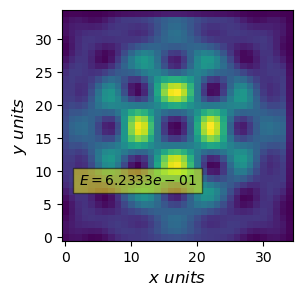

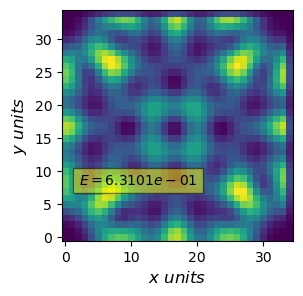

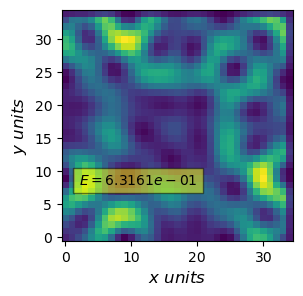

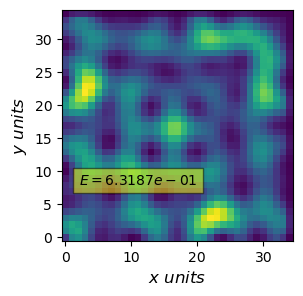

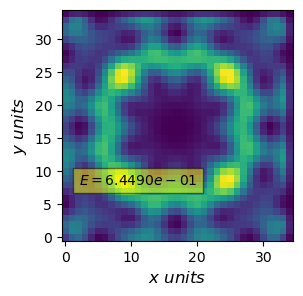

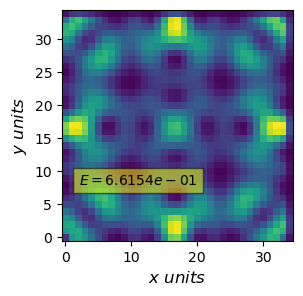

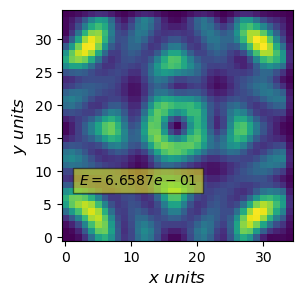

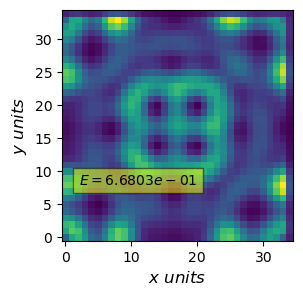

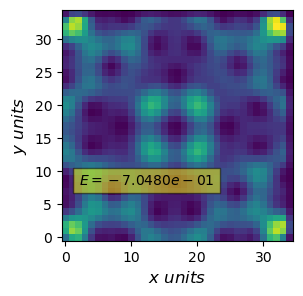

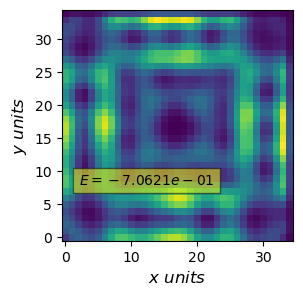

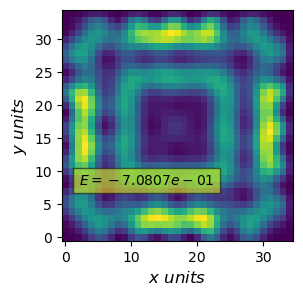

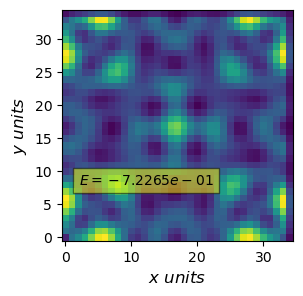

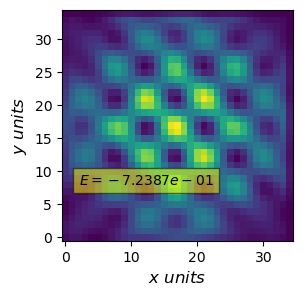

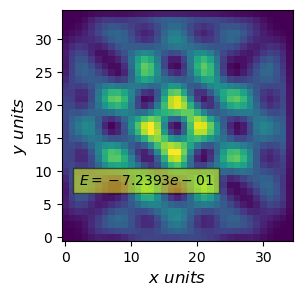

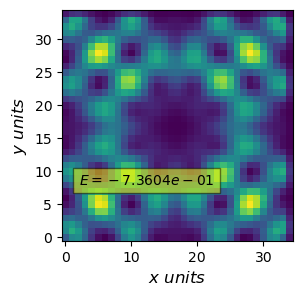

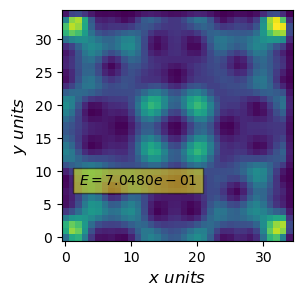

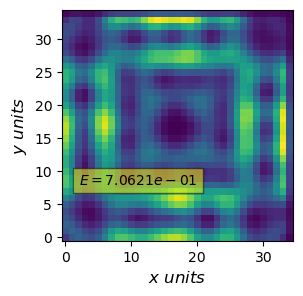

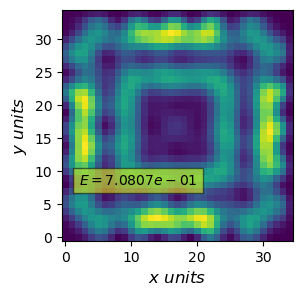

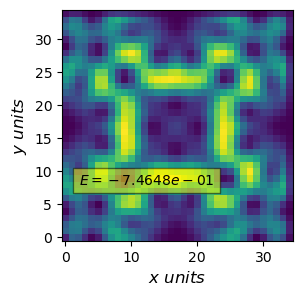

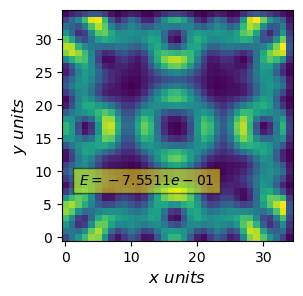

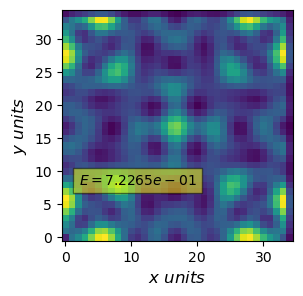

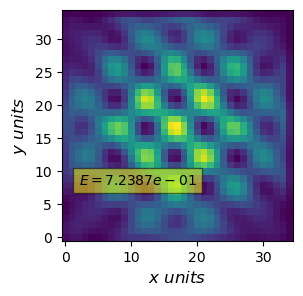

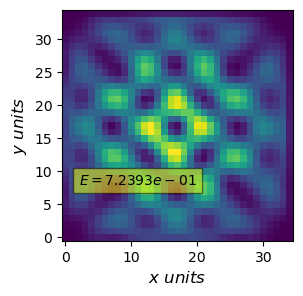

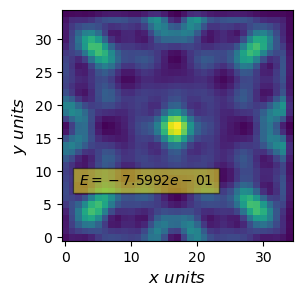

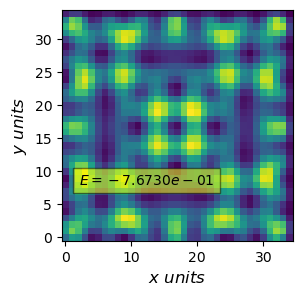

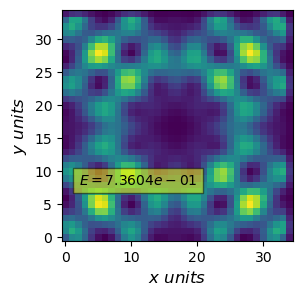

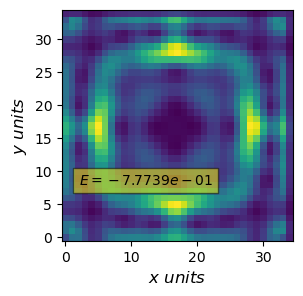

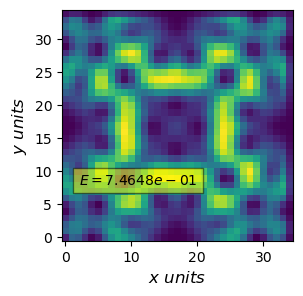

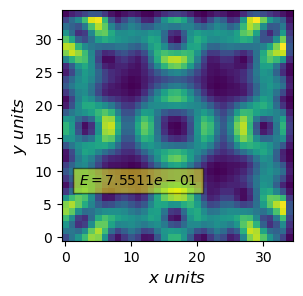

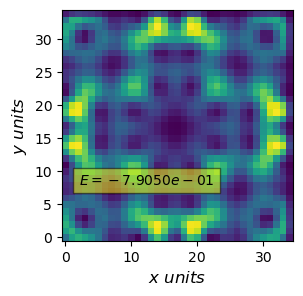

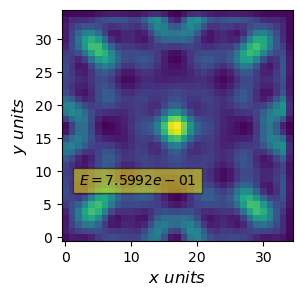

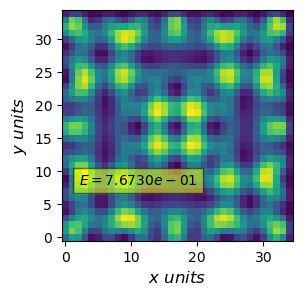

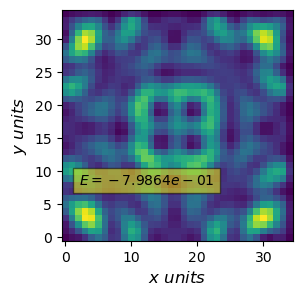

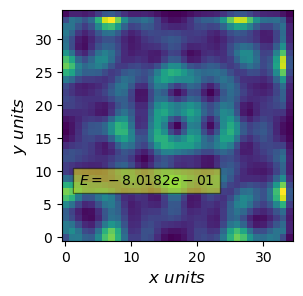

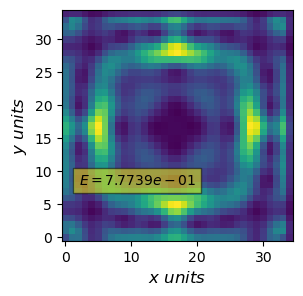

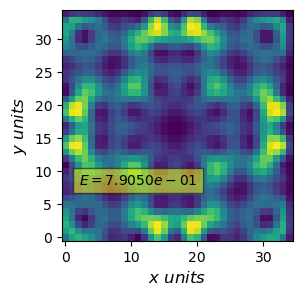

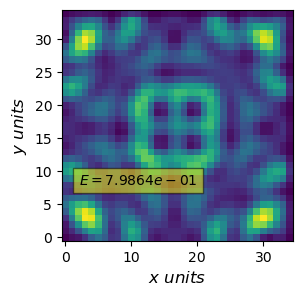

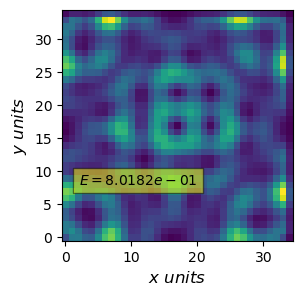

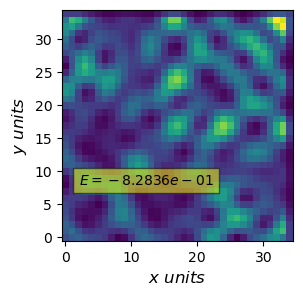

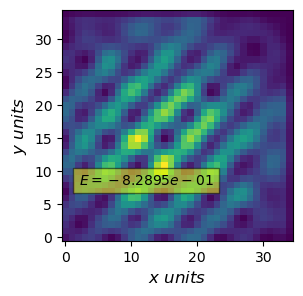

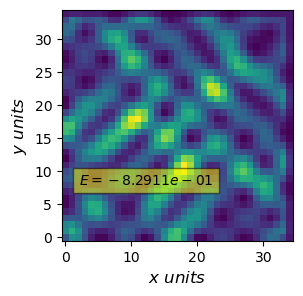

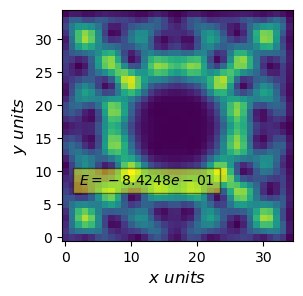

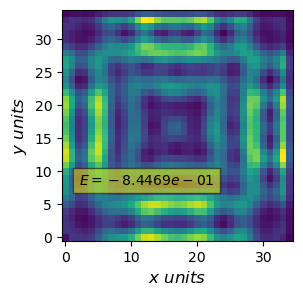

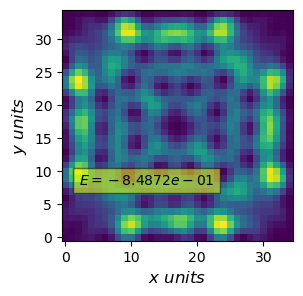

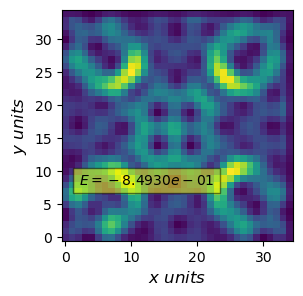

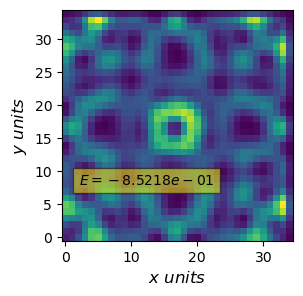

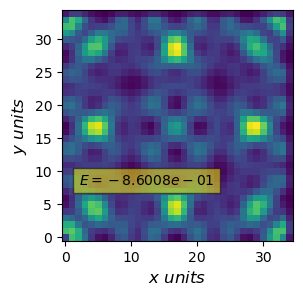

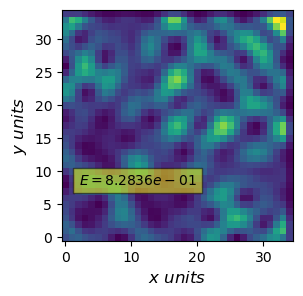

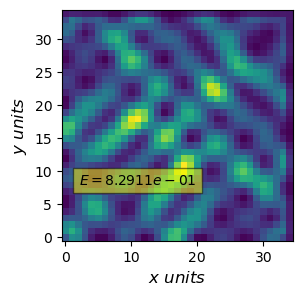

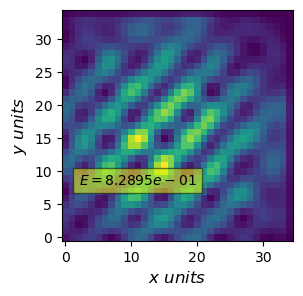

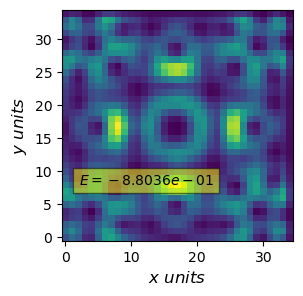

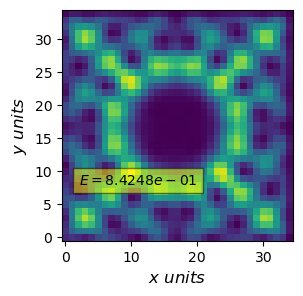

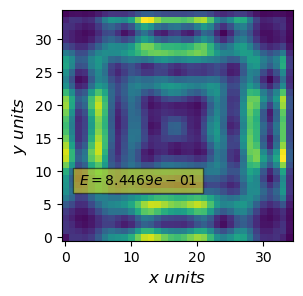

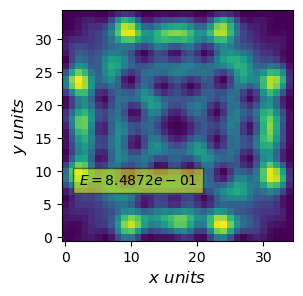

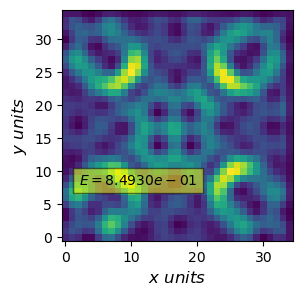

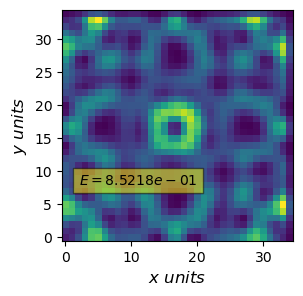

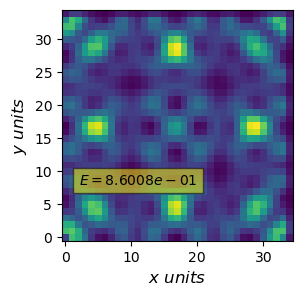

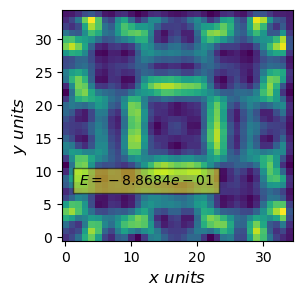

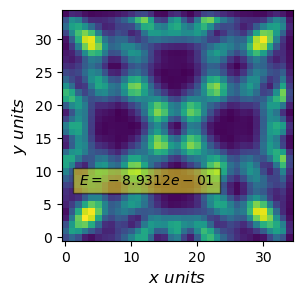

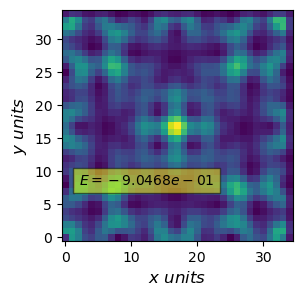

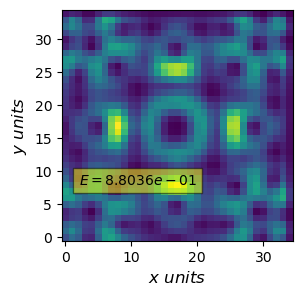

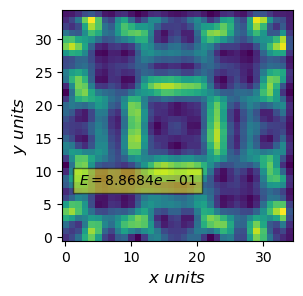

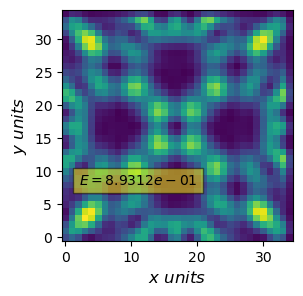

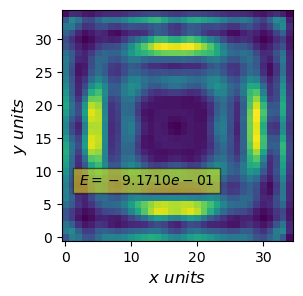

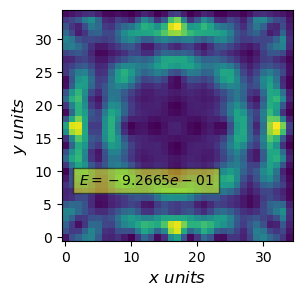

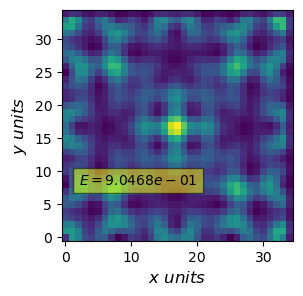

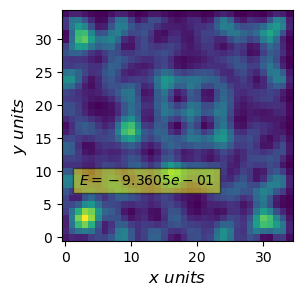

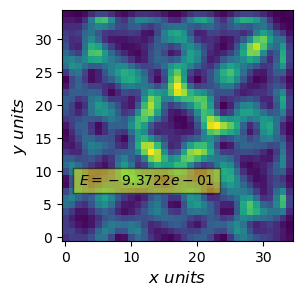

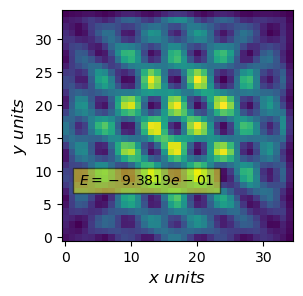

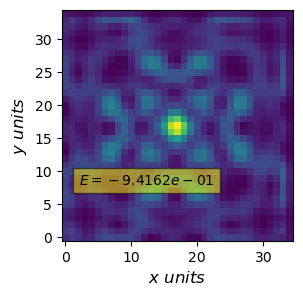

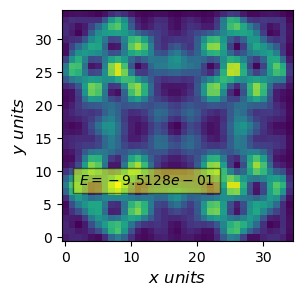

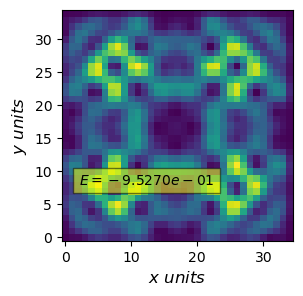

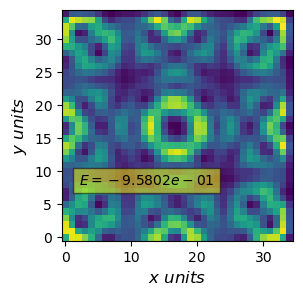

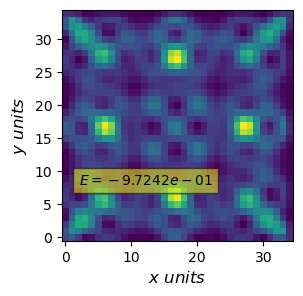

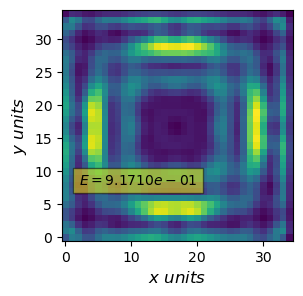

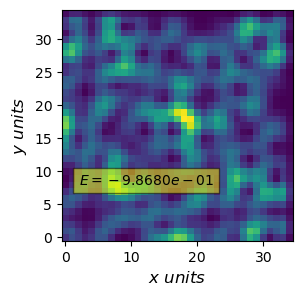

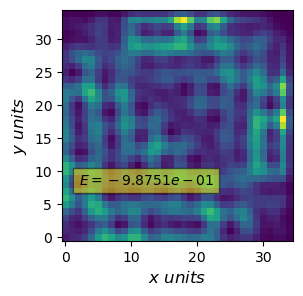

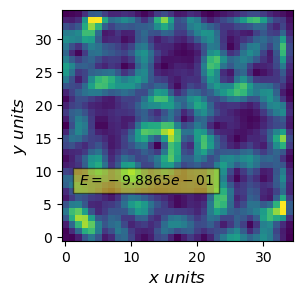

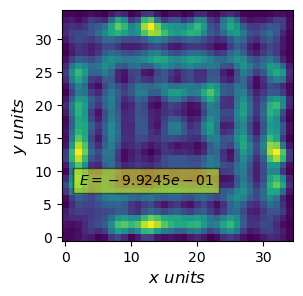

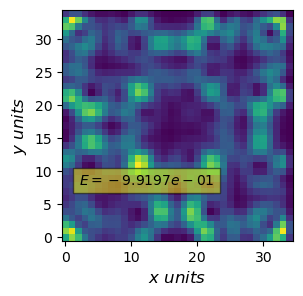

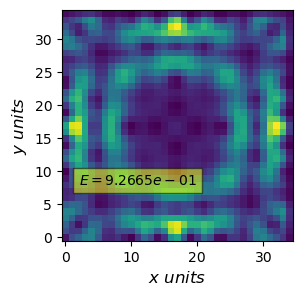

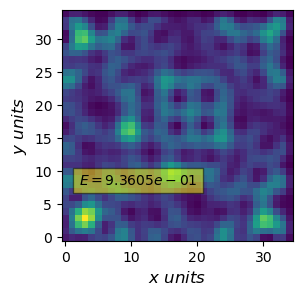

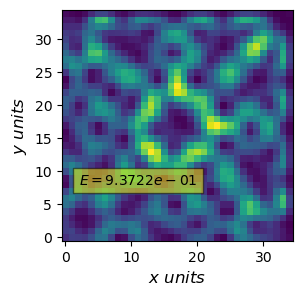

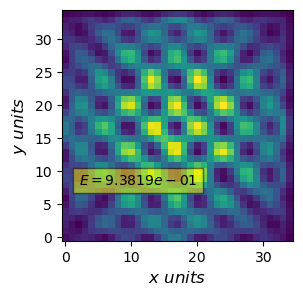

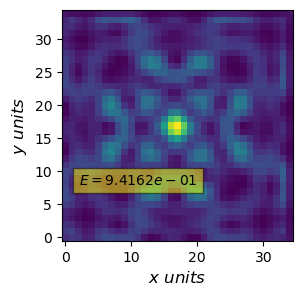

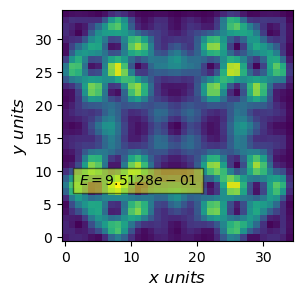

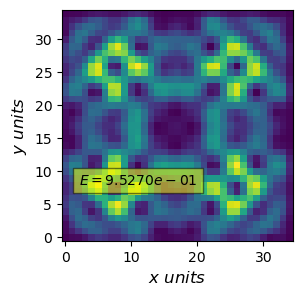

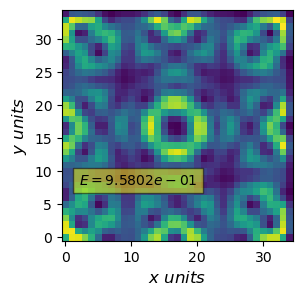

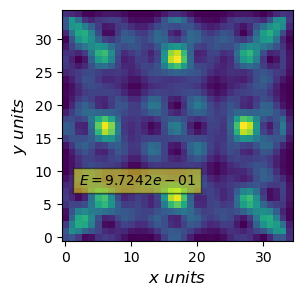

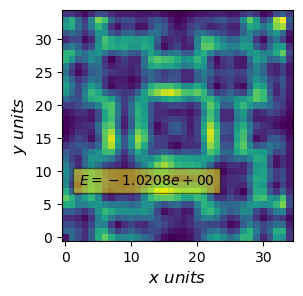

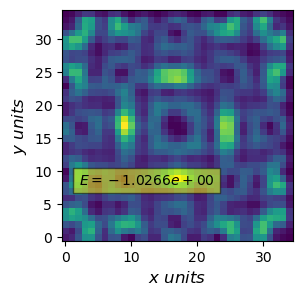

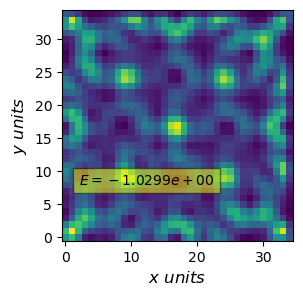

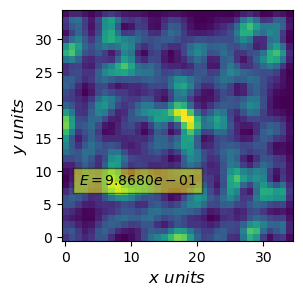

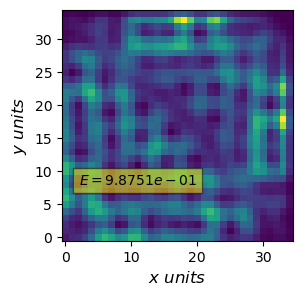

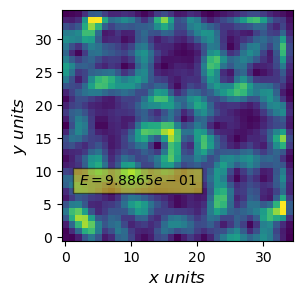

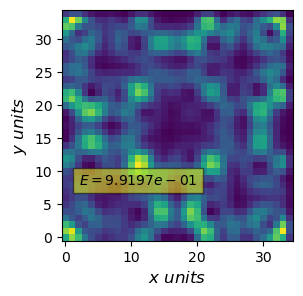

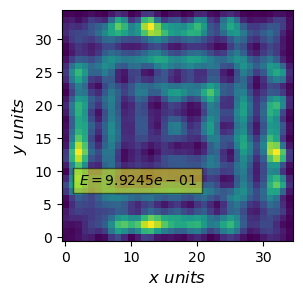

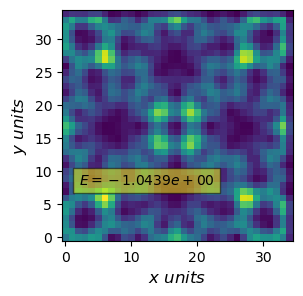

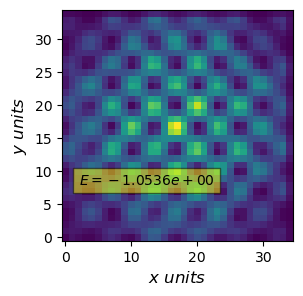

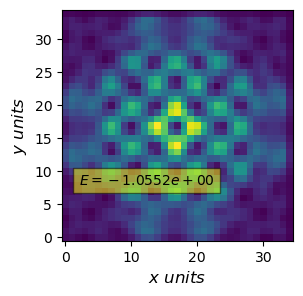

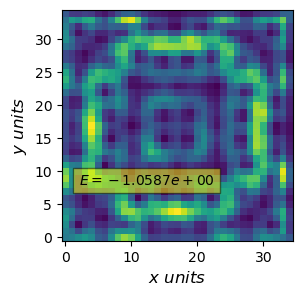

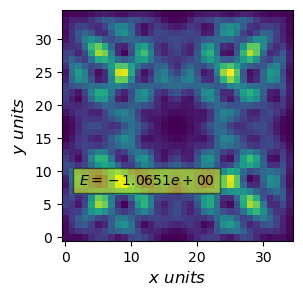

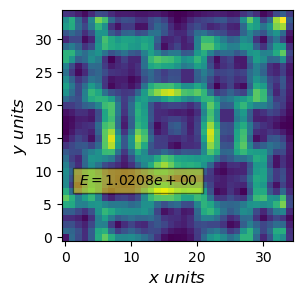

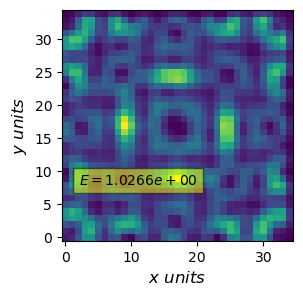

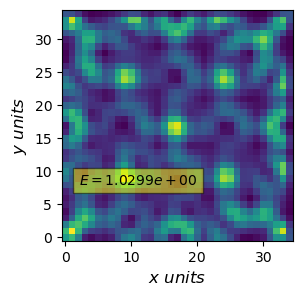

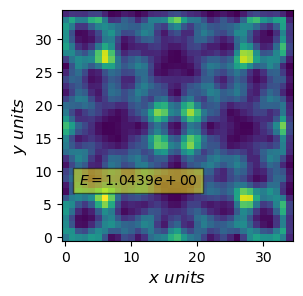

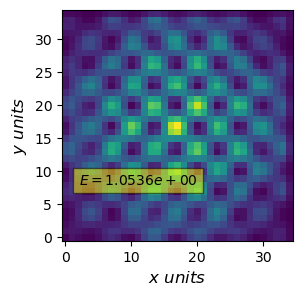

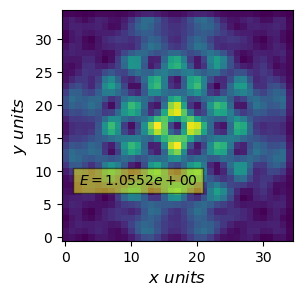

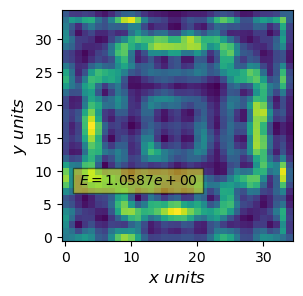

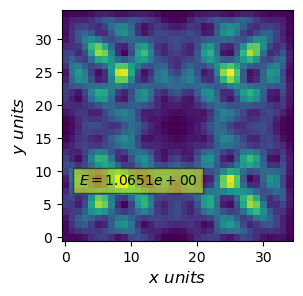

In [25]:
for i in range(nbands):
    to_plot = states[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0, origin = 'lower')
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{ener[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)
    
    
    fig.show()